### Mapping human lymph node cell types using 10X Genomics Visium and `cell2location`

- **Developed by**: Vitalii Kleschevnikov - ICB
- **Modified by**: Carlos Talavera-López - WüSI
- **Last modified**: 240708

This tutorial shows how to use `cell2location` method for spatially resolving fine-grained cell types by integrating 10X Genomics Visium data with scRNA-seq reference of cell types.

`cell2location` is a principled Bayesian model that estimates which combination of cell types in which cell abundance could have given the mRNA counts in the spatial data, while modelling technical effects (platform/technology effect, contaminating RNA, unexplained variance).

<div class="alert alert-info">
<b>Note!</b>

`cell2location` is an independent package, but is powered by `scvi-tools`. If you have questions about `cell2location`, 10X Genomics Visium data or `scvi-tools` please visit https://discourse.scverse.org/c/ecosytem/cell2location/42, https://discourse.scverse.org/c/general/visium/32 or https://discourse.scverse.org/c/help/scvi-tools/7 correspondingly.

</div>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BayraktarLab/cell2location/blob/master/docs/notebooks/cell2location_tutorial.ipynb)

In this tutorial, we analyse a publicly available Visium dataset of the human lymph node from 10X Genomics, and spatially map a comprehensive atlas of 34 reference cell types derived by integration of scRNA-seq datasets from human secondary lymphoid organs.

- Cell2location provides high sensitivity and resolution by borrowing statistical strength across locations. This is achieved by modelling similarity of location patterns between cell types using a hierarchical factorisation of cell abundance into tissue zones as a prior (see paper methods).

- Using our statistical method based on Negative Binomial regression to robustly combine scRNA-seq reference data across technologies and batches results in improved spatial mapping accuracy. Given cell type annotation for each cell, the corresponding reference cell type signatures $g_{f,g}$, which represent the average mRNA count of each gene $g$ in each cell type $f$, can be estimated from sc/snRNA-seq data using either 1) NB regression or 2) a hard-coded computation of per-cluster average mRNA counts for individual genes.  We generally recommend using NB regression. This notebook shows use a dataset composed on multiple batches and technologies.When the batch effects are small, a faster hard-coded method of computing per cluster averages provides similarly high accuracy. We also recommend the hard-coded method for non-UMI technologies such as Smart-Seq 2.

- Cell2location needs untransformed unnormalised spatial mRNA counts as input.

- You also need to provide cell2location with the expected average cell abundance per location which is used as a prior to guide estimation of absolute cell abundance. This value depends on the tissue and can be estimated by counting nuclei for a few locations in the paired histology image but can be approximate (see [paper methods for more guidance](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf)).


## Workflow diagram

![Figure 1.](https://raw.githubusercontent.com/BayraktarLab/cell2location/master/docs/images/FigS1_cell2location_workflow.png)  


## Contents
* [Loading packages](#Loading-packages)
* [Loading Visium and single cell data data](#Loading-Visium-and-scRNA-seq-reference-data)
1. [Estimating cell type signatures (NB regression)](#Estimation-of-reference-cell-type-signatures-(NB-regression))
2. [Cell2location: spatial mapping](#Cell2location:-spatial-mapping)
3. [Visualising cell abundance in spatial coordinates](#Visualising-cell-abundance-in-spatial-coordinates)
4. [Downstream analysis](#Downstream-analysis)
* [Leiden clustering of cell abundance](#Identifying-discrete-tissue-regions-by-Leiden-clustering)
* [Identifying cellular compartments / tissue zones using matrix factorisation (NMF)](#Identifying-cellular-compartments-/-tissue-zones-using-matrix-factorisation-(NMF))
* [Estimate cell-type specific expression of every gene in the spatial data (needed for NCEM)](#Estimate-cell-type-specific-expression-of-every-gene-in-the-spatial-data-(needed-for-NCEM))
5. [Advanced use](#Advanced-use)
* [Working with the posterior distribution and computing arbitrary quantiles](#Working-with-the-posterior-distribution-and-computing-arbitrary-quantiles)

## Loading packages <a class="anchor" id="Loading-packages"></a>

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           
DEPRECATION: git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

First, let's define where we save the results of our analysis:

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
results_folder = '/content/drive/My Drive/results/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Loading Visium and scRNA-seq reference data <a class="anchor" id="Loading-Visium-and-scRNA-seq-reference-data"></a>

First let's read spatial Visium data from 10X Space Ranger output. Here we use lymph node data generated by 10X and presented in [Kleshchevnikov et al (section 4, Fig 4)](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1). This dataset can be conveniently downloaded and imported using scanpy. See [this tutorial](https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_short_demo.html) for a more extensive and practical example of data loading (multiple visium samples).

In [ ]:
adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

  0%|          | 0.00/7.86M [00:00<?, ?B/s]

  0%|          | 0.00/29.3M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


<div class="alert alert-info">
<b>Note!</b>
    
Here we rename genes to ENSEMBL ID for correct matching between single cell and spatial data - so you can ignore the scanpy suggestion to call `.var_names_make_unique`.
</div>

In [ ]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

You can still plot gene expression by name using standard scanpy functions as follows:
```python
sc.pl.spatial(color='PTPRC', gene_symbols='SYMBOL', ...)
```

<div class="alert alert-info">
<b>Note!</b>
    
Mitochondia-encoded genes (gene names start with prefix mt- or MT-) are irrelevant for spatial mapping because their expression represents technical artifacts in the single cell and nucleus data rather than biological abundance of mitochondria. Yet these genes compose 15-40% of mRNA in each location. Hence, to avoid mapping artifacts we strongly recommend removing mitochondrial genes.
</div>

In [ ]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

Published scRNA-seq datasets of lymph nodes have typically lacked an adequate representation of germinal centre-associated immune cell populations due to age of patient donors. We, therefore, include scRNA-seq datasets spanning lymph nodes, spleen and tonsils in our single-cell reference to ensure that we captured the full diversity of immune cell states likely to exist in the spatial transcriptomic dataset.

Here we download this dataset, import into anndata and change variable names to ENSEMBL gene identifiers.

In [ ]:
# Read data
adata_ref = sc.read(
    f'./data/sc.h5ad',
    backup_url='https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad'
)

  0%|          | 0.00/527M [00:00<?, ?B/s]

<div class="alert alert-warning">
<b>Warning</b>
    
Here we rename genes to ENSEMBL ID for correct matching between single cell and spatial data.
</div>

In [ ]:
adata_ref.var['SYMBOL'] = adata_ref.var.index
# rename 'GeneID-2' as necessary for your data
adata_ref.var.set_index('GeneID-2', drop=True, inplace=True)

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del adata_ref.raw

<div class="alert alert-info">
<b>Note!</b>
    
Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes while removing most of the uninformative genes.
</div>

The default parameters `cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12` are a good starting point, however, you can increase the cut-off to exclude more genes. To preserve marker genes of rare cell types we recommend low `cell_count_cutoff=5`, however, `cell_percentage_cutoff2` and `nonz_mean_cutoff` can be increased to select between 8k-16k genes.

In this 2D histogram, orange rectangle highlights genes excluded based on the combination of number of cells expressing that gene (Y-axis) and average RNA count for cells where the gene was detected (X-axis).

In this case, the downloaded dataset was already filtered using this method, hence no density under the orange rectangle (to be changed in the future version of the tutorial).

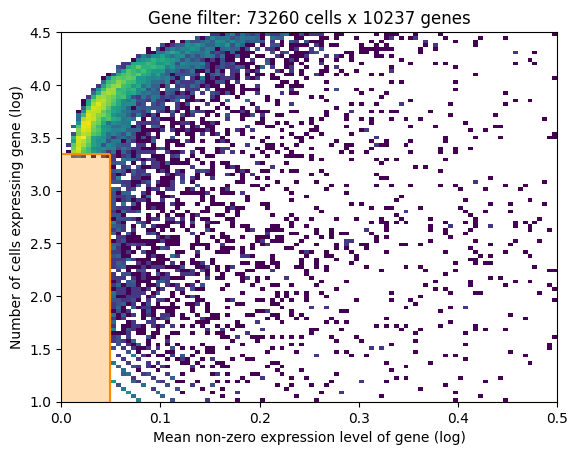

In [ ]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

## Estimation of reference cell type signatures (NB regression) <a class="anchor" id="Estimation-of-reference-cell-type-signatures-(NB-regression)"></a>

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

<div class="alert alert-block alert-message">
<b>Preparing anndata.</b>
    
First, prepare anndata object for the regression model:
</div>

In [ ]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='Subset',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['Method']
                       )

In [ ]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': ['Method'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  23   │
│         n_cells          │ 73260 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  34   │
│          n_vars          │ 10237 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │    4861STDY7135913     │          0          │
│                     │    4861STDY7135914     │          1          │
│                     │    4861STDY7208412     │          2          │
│                     │    4861STDY7208413     │          3          │
│                     │    4861STDY7462253     │          4          │
│                     │    4861STDY7462254     │          5          │
│                     │    4861STDY7462255     │          6          │
│                     │    4861STDY7462256     │          7          │
│                     │    4861STDY7528597     │          8          │
│                     │    4861STDY7528598     │          9          │
│                     │    4861STDY7528599     │         10          │
│                     │    4861STDY7528600     │         11          │
│                     │      BCP002_Total      │         12          │
│                     │      BCP003_Total      │         13          │
│                     │      BCP004_Total      │         14          │
│                     │      BCP005_Total      │         15          │
│                     │      BCP006_Total      │         16          │
│                     │      BCP008_Total      │         17          │
│                     │      BCP009_Total      │         18          │
│                     │ Human_colon_16S7255677 │         19          │
│                     │ Human_colon_16S7255678 │         20          │
│                     │ Human_colon_16S8000484 │         21          │
│                     │      Pan_T7935494      │         22          │
└─────────────────────┴────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │    B_Cycling     │          0          │
│                     │     B_GC_DZ      │          1          │
│                     │     B_GC_LZ      │          2          │
│                     │    B_GC_prePB    │          3          │
│                     │      B_IFN       │          4          │
│                     │   B_activated    │          5          │
│                     │      B_mem       │          6          │
│                     │     B_naive      │          7          │
│                     │     B_plasma     │          8          │
│                     │     B_preGC      │          9          │
│                     │     DC_CCR7+     │         10          │
│                     │     DC_cDC1      │         11          │
│                     │     DC_cDC2      │         12          │
│                     │      DC_pDC      │         13          │
│                     │       Endo       │         14          │
│                     │       FDC        │         15          │
│                     │       ILC        │         16          │
│                     │  Macrophages_M1  │         17          │
│                     │  Macrophages_M2  │         18          │
│                     │       Mast       │         19          │
│                     │    Monocytes     │         20          │
│                     │        NK        │         21          │
│                     │       NKT        │         22          │
│                     │      T_CD4+      │         23          │
│                     │    T_CD4+_TfH    │         24          │
│                     │  T_CD4+_TfH_GC   │         25          │
│                     │   T_CD4+_naive   │         26          │
│                     │  T_CD8+_CD161+   │         27          │
│                     │ T_CD8+_cytotoxic │         28          │
│                     │   T_CD8+_naive   │         29          │
│                     │     T_TIM3+      │         30          │
│                     │      T_TfR       │         31          │
│                     │      T_Treg      │         32          │
│                     │       VSMC       │         33          │
└─────────────────────┴──────────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Method'] │    3GEX    │          0          │
│                     │    5GEX    │          1          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

<div class="alert alert-block alert-message">
<b>Training model.</b>
    
Now we train the model to estimate the reference cell type signatures.
    
Note that to achieve convergence on your data (=to get stabilization of the loss) you may need to increase `max_epochs=250` (See below).
    
Also note that here we are using `batch_size=2500` which is much larger than scvi-tools default and perform training on all cells in the data (`train_size=1`) - both parameters are defaults.
</div>

In [ ]:
mod.train(max_epochs=50, accelerator="auto")

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Epoch 18/50:  34%|███▍      | 17/50 [1:09:31<2:17:28, 249.94s/it, v_num=1, elbo_train=2.93e+8]

<div class="alert alert-block alert-message">
<b>Determine if the model needs more training.</b>
</div>

Here, we plot ELBO loss history during training, removing first 20 epochs from the plot.
This plot should have a decreasing trend and level off by the end of training. If it is still decreasing, increase `max_epochs`.

In [ ]:
mod.plot_history(20)

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

You can compute the 5%, 50% and 95% quantiles of the posterior distribution directly rather than using 1000 samples from the distribution (or any other quantiles). This speeds up application on large datasets and requires less memory - however, posterior mean and standard deviation cannot be computed this way.

```python
adata_ref = mod.export_posterior(
    adata_ref, use_quantiles=True,
    # choose quantiles
    add_to_obsm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 2500, 'use_gpu': True}
)
```

<div class="alert alert-block alert-message">
<b>Examine QC plots.</b>
</div>

1. Reconstruction accuracy to assess if there are any issues with inference. This 2D histogram plot should have most observations along a noisy diagonal.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

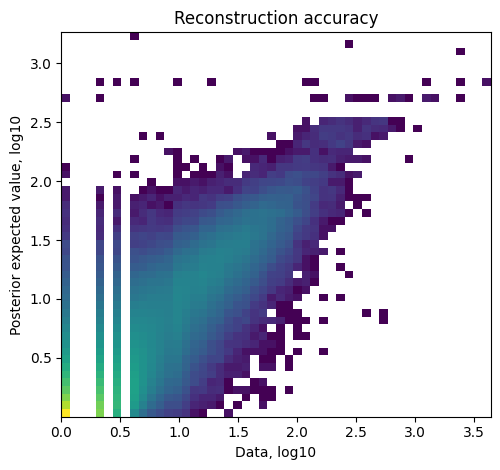

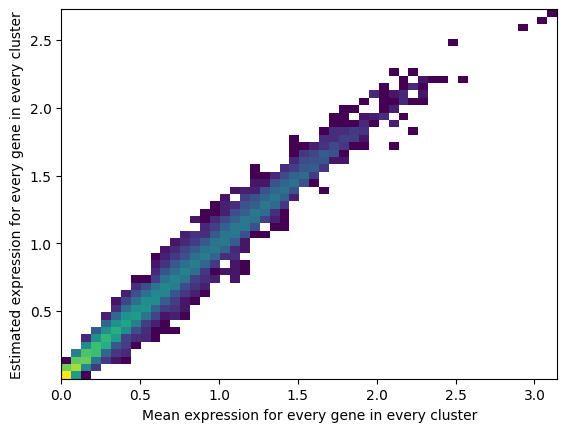

In [ ]:
mod.plot_QC()

The model and output h5ad can be loaded later like this:
```python
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)
```

<div class="alert alert-block alert-message">
<b>Extracting reference cell types signatures as a pd.DataFrame.</b>
    
All parameters of the a Negative Binomial regression model are exported into reference anndata object, however for spatial mapping we just need the estimated expression of every gene in every cell type. Here we extract that from standard output:
</div>

In [ ]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B_Cycling,B_GC_DZ,B_GC_LZ,B_GC_prePB,B_IFN
GeneID-2,,,,,
ENSG00000188976,0.373422,0.217961,0.272854,0.302474,0.137330
ENSG00000188290,0.002165,0.000677,0.000674,0.027257,0.046026
ENSG00000187608,0.428862,0.256968,0.321992,0.516135,3.859654
ENSG00000186891,0.021799,0.001119,0.052500,0.051707,0.008939
ENSG00000186827,0.007251,0.000539,0.006395,0.022949,0.008891


## Cell2location: spatial mapping <a class="anchor" id="Cell2location:-spatial-mapping"></a>

<div class="alert alert-block alert-message">
<b>Find shared genes and prepare anndata.</b>
Subset both anndata and reference signatures:
</div>

In [ ]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

<div class="alert alert-info">
<b> Important </b>
    
To use cell2location spatial mapping model, you need to specify 2 user-provided hyperparameters (`N_cells_per_location` and `detection_alpha`) - for detailed guidance on setting these hyperparameters and their impact see [the flow diagram and the note](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf).
</div>

**Choosing hyperparameter `N_cells_per_location`!**

It is useful to adapt the expected cell abundance `N_cells_per_location` to every tissue</b>. This value can be estimated from paired histology images and as described in the note above. Change the value presented in this tutorial (`N_cells_per_location=30`) to the value observed in your your tissue.

**Choosing hyperparameter `detection_alpha`!**

To improve accuracy & sensitivity on datasets with large technical variability in RNA detection sensitivity within the slide/batch - you need to relax regularisation of per-location normalisation (use `detection_alpha=20`). High technical variability in RNA detection sensitivity is present in your sample when you observe the spatial distribution of total RNA count per location that doesn't match expected cell numbers based on histological examination.

We initially opted for high regularisation (`detection_alpha=200`) as a default because the mouse brain & human lymph node datasets used in our paper have low technical effects and using high regularisation strenght improves consistencly between total estimated cell abundance per location and the nuclei count quantified from histology ([Fig S8F in cell2location paper](https://static-content.springer.com/esm/art%3A10.1038%2Fs41587-021-01139-4/MediaObjects/41587_2021_1139_MOESM1_ESM.pdf)). However, in many collaborations, we see that Visium experiments on human tissues suffer from technical effects. This motivates the new default value of `detection_alpha=20` and the recommendation of testing both settings on your data (`detection_alpha=20` and `detection_alpha=200`).

In [ ]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 4035  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 10217 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                       batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ V1_Human_Lymph_Node │          0          │
└─────────────────────┴─────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

<div class="alert alert-block alert-message">
<b>Training cell2location:</b>
</div>

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a

Epoch 3000/3000: 100%|██████████| 3000/3000 [08:34<00:00,  6.11it/s, v_num=1, elbo_train=4.56e+7]

INFO: `Trainer.fit` stopped: `max_epochs=3000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 3000/3000: 100%|██████████| 3000/3000 [08:34<00:00,  5.83it/s, v_num=1, elbo_train=4.56e+7]


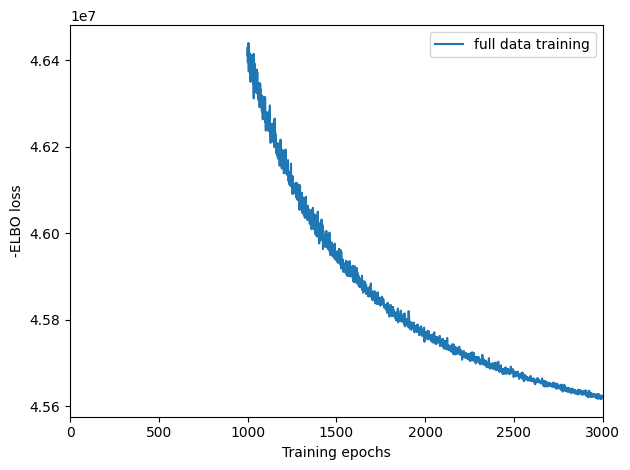

In [ ]:
mod.train(max_epochs=3000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          accelerator="auto",
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

<div class="alert alert-block alert-message">
<b>Exporting estimated posterior distributions of cell abundance and saving results:</b>
</div>

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
results_folder = '/content/drive/My Drive/results/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

data_vis = sc.read_h5ad(f"{run_name}/sp.h5ad")
adata_ref = sc.read_h5ad(f"{ref_run_name}/sc.h5ad")


### upload model (pkl)
import torch
mod = torch.load(f"{run_name}")
mod2 = torch.load(f"{ref_run_name}")

The model and output h5ad can be loaded later like this:
```python
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)
```

<div class="alert alert-block alert-message">
<b>Assessing mapping quality.</b>
Examine reconstruction accuracy to assess if there are any issues with mapping.
The plot should be roughly diagonal, strong deviations will signal problems that need to be investigated.
</div>

In [ ]:
mod.plot_QC()

When intergrating multiple spatial batches and when working with datasets that have substantial variation of detected RNA within slides (that cannot be explained by high cellular density in the histology), it is important to assess whether cell2location normalised those effects. You expect to see similar total cell abundance across batches but distinct RNA detection sensitivity (both estimated by cell2location). You expect total cell abundance to mirror high cellular density in the histology.

```python
fig = mod.plot_spatial_QC_across_batches()
```

## Visualising cell abundance in spatial coordinates <a class="anchor" id="Visualising-cell-abundance-in-spatial-coordinates"></a>

<div class="alert alert-info">
Note
    
We use 5% quantile of the posterior distribution, representing the value of cell abundance that the model has high confidence in (aka 'at least this amount is present').
</div>

In [ ]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC',
                         'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

In [ ]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['T_CD4+_naive', 'B_naive', 'FDC']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

## Downstream analysis <a class="anchor" id="Downstream-analysis"></a>

### Identifying discrete tissue regions by Leiden clustering<a class="anchor" id="Identifying-discrete-tissue-regions-by-Leiden-clustering"></a>

We identify tissue regions that differ in their cell composition by clustering locations using cell abundance estimated by cell2location.

We find tissue regions by clustering Visium spots using estimated cell abundance each cell type. We constuct a K-nearest neigbour (KNN) graph representing similarity of locations in estimated cell abundance and then apply Leiden clustering. The number of KNN neighbours should be adapted to size of dataset and the size of anatomically defined regions (e.i. hippocampus regions are rather small compared to size of the brain so could be masked by large `n_neighbors`). This can be done for a range KNN neighbours and Leiden clustering resolutions until a clustering matching the anatomical structure of the tissue is obtained.

The clustering is done jointly across all Visium sections / batches, hence the region identities are directly comparable. When there are strong technical effects between multiple batches (not the case here) `sc.external.pp.bbknn` can be in principle used to account for those effects during the KNN construction.

The resulting clusters are saved in `adata_vis.obs['region_cluster']`.

In [ ]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:576: RuntimeWarning: overflow encountered in cast
  knn_dists = knn_dists.astype(np.float32)
<ipython-input-24-d88c62c6d498>:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_vis, resolution=1.1)


We can use the location composition similarity graph to build a joint integrated UMAP representation of all section/Visium batches.

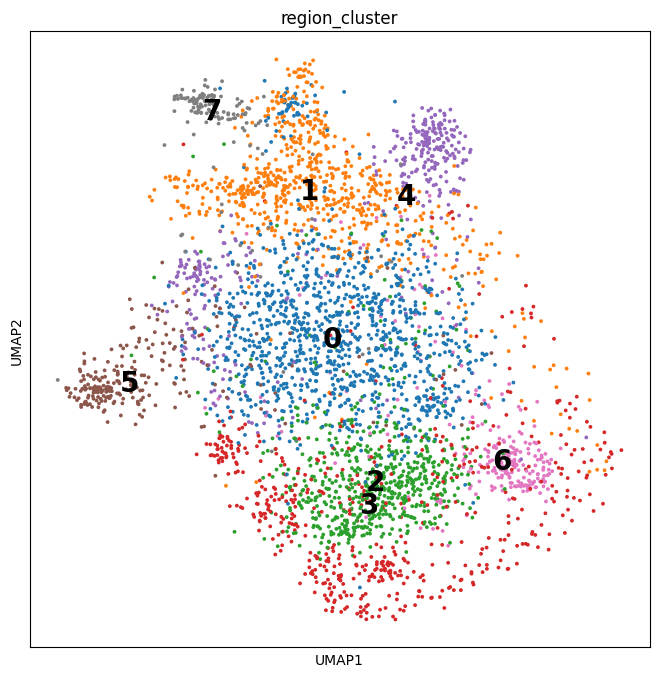

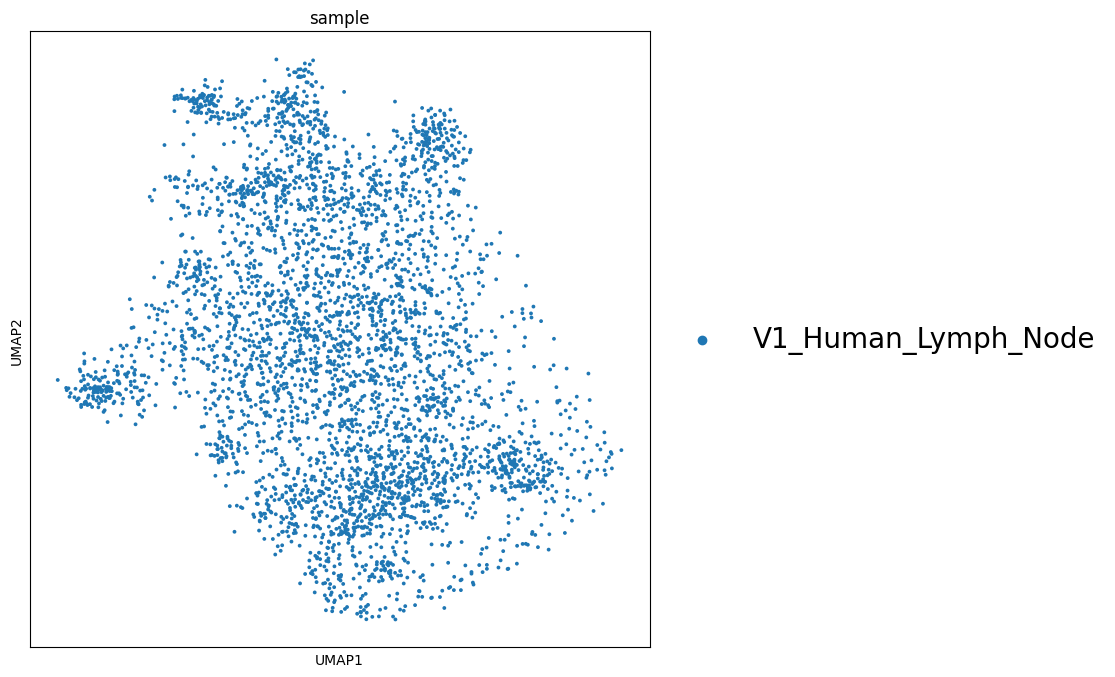

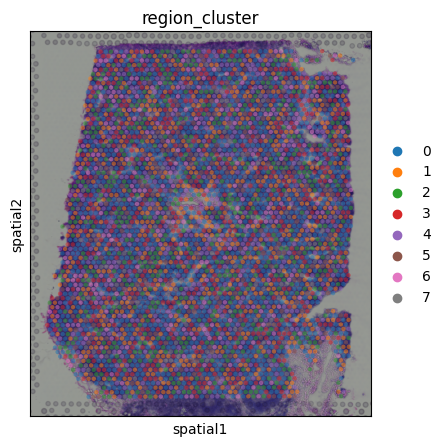

In [ ]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)

### Identifying cellular compartments / tissue zones using matrix factorisation (NMF) <a name="Identifying-cellular-compartments-/-tissue-zones-using-matrix-factorisation-(NMF)"></a>

Here, we use the cell2location mapping results to identify the spatial co-occurrence of cell types in order to better understand the tissue organisation and predict cellular interactions. We performed non-negative matrix factorization (NMF) of the cell type abundance estimates from cell2location ([paper section 4, Fig 4D](https://www.nature.com/articles/s41587-021-01139-4)). Similar to the established benefits of applying NMF to conventional scRNA-seq, the additive NMF decomposition yielded a grouping of spatial cell type abundance profiles into components that capture co-localised cell types ([Supplemenary Methods section 4.2, p. 60](https://www.nature.com/articles/s41587-021-01139-4#Sec50)). This NMF-based decomposition naturally accounts for the fact that multiple cell types and microenvironments can co-exist at the same Visium locations (see [paper Fig S20, p. 34](https://www.nature.com/articles/s41587-021-01139-4#Sec50)), while sharing information across tissue areas (e.g. individual germinal centres).


<div class="alert alert-block alert-primary">
<b>Tip</b>
    
In practice, it is better to train NMF for a range of factors $R={5, .., 30}$ and select $R$ as a balance between capturing fine-grained and splitting known well-established tissue zones.

If you want to find a few most disctinct cellular compartments, use a small number of factors.   
If you want to find very strong co-location signal and assume that most cell types don't co-locate, use a lot of factors (> 30 - used here).
</div>

Below we show how to perform this analysis. To aid this analysis, we wrapped the analysis shown the notebook on advanced downstream analysis into a pipeline that automates training of the NMF model with varying number of factors:

In [ ]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_4035locations_34factors


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_4035locations_34factors


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


For every factor number, the model produces the following list of folder outputs:

`cell_type_fractions_heatmap/`: a dot plot of the estimated NMF weights of cell types (rows) across NMF components (columns)

`cell_type_fractions_mean/`: the data used for dot plot

`factor_markers/`: tables listing top 10 cell types most speficic to each NMF factor

`models/`: saved NMF models

`predictive_accuracy/`: 2D histogram plot showing how well NMF explains cell2location output

`spatial/`: NMF weights across locatinos in spatial coordinates

`location_factors_mean/`: the data used for the plot in spatial coordiantes

`stability_plots/`: stability of NMF weights between training restarts

Key output that you want to examine are the files in `cell_type_fractions_heatmap/` which show a dot plot of the estimated NMF weights of cell types (rows) across NMF components (columns) which correspond to cellular compartments. Shown are relative weights, normalized across components for every cell type.

<div class="alert alert-block alert-primary">
<b>Tip</b>
    
The NMF model output such as factor loadings are stored in `adata.uns[f"mod_coloc_n_fact{n_fact}"]` in a similar output format as main cell2location results in `adata.uns['mod']`.
</div>

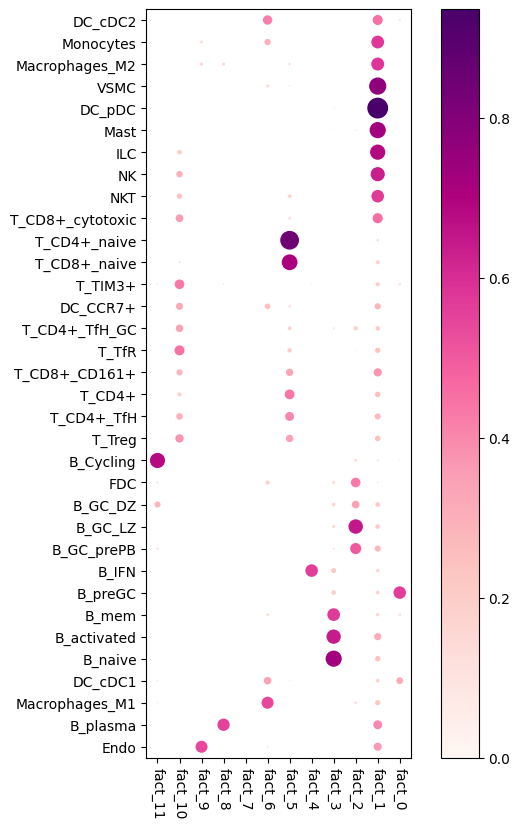

In [ ]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()

### Estimate cell-type specific expression of every gene in the spatial data (needed for NCEM) <a name="Estimate-cell-type-specific-expression-of-every-gene-in-the-spatial-data-(needed-for-NCEM)"></a>

The cell-type specific expression of every gene at every spatial location in the spatial data enables learning cell communication with NCEM model using Visium data (https://github.com/theislab/ncem).

To derive this, we adapt the approach of estimating conditional expected expression proposed by [RCTD (Cable et al)](https://pubmed.ncbi.nlm.nih.gov/33603203/) method.

With cell2location, we can look at the posterior distribution rather than just point estimates of cell type specific expression (see `mod.samples.keys()` and next section on using full distribution).

**Note that this analysis requires substantial amount of RAM memory and thefore doesn't work on free Google Colab (12 GB limit).**

In [ ]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
   adata_vis.layers[n] = expected_dict['mu'][i]


In [ ]:
# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'./results/lymph_nodes_analysis//cell2location_map/sp.h5ad'

<div class="alert alert-block alert-primary">
<b>Plotting cell-type specific expression of genes in spatial coordinates.</b>
    
Below we plot the cell-type specific expression of genes (rows, second to last columns) compared to total expression of those genes (first column).

Here we highlight *CD3D*, pan T-cell marker expressed by 2 subtypes of T cells in distinct locations but not expressed by co-located B cells, that instead express *CR2* gene.
</div>

In [ ]:
from tutorial_utils import plot_genes_per_cell_type

ModuleNotFoundError: No module named 'tutorial_utils'

In [ ]:
# list cell types and genes for plotting
ctypes = ['T_CD4+_TfH_GC', 'T_CD4+_naive', 'B_GC_LZ']
genes = ['CD3D', 'CR2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')
    plot_genes_per_cell_type(slide, genes, ctypes);

NameError: name 'plot_genes_per_cell_type' is not defined

Note that `plot_genes_per_cell_type` function often need customization so it is not included into cell2location package - you need to copy it from https://github.com/BayraktarLab/cell2location/blob/master/docs/notebooks/tutorial_utils.py to use on your system.

## Advanced use <a name="advanced"></a>

### Working with the posterior distribution and computing arbitrary quantiles <a name="Working-with-the-posterior-distribution-and-computing-arbitrary-quantiles"></a>

In addition to the posterior distribution mean, std and quantiles presented earlier in the notebook you can fetch an arbitrary number of samples from the posterior distribution. To limit memory use, it could be beneficial to select particular varibles in the model.

Note that this analysis requires substantial amount RAM memory and thefore doesn't work on Google Colab.

In [ ]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

Sampling global variables, sample: 100%|██████████| 999/999 [00:35<00:00, 28.13it/s]


(1000, 4035, 34)

Finally, it could be useful to compute arbitrary quantiles of the posterior distribution.

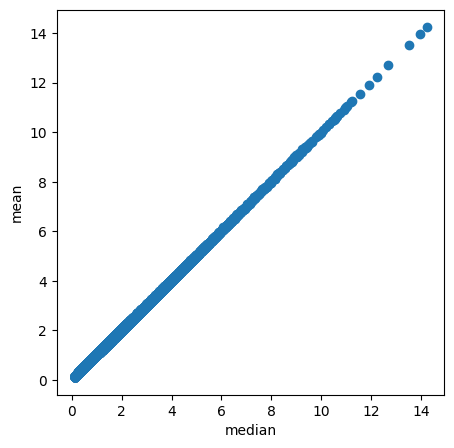

In [ ]:
# Compute any quantile of the posterior distribution
medians = mod.posterior_quantile(q=0.5, batch_size=mod.adata.n_obs)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');

### Modules and their versions used for this analysis


Useful for debugging and reporting issues.

In [ ]:
cell2location.utils.list_imported_modules()

sys 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
re 2.2.1
ipykernel._version 5.5.6
json 2.0.9
IPython.core.release 7.34.0
logging 0.5.1.2
zlib 1.0
traitlets._version 5.7.1
traitlets 5.7.1
socketserver 0.4
argparse 1.1
platform 1.0.8
pygments 2.16.1
ptyprocess 0.7.0
pexpect 4.9.0
IPython.core.crashhandler 7.34.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
_sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
sqlite3 2.6.0
wcwidth 0.2.13
prompt_toolkit 3.0.47
parso 0.8.4
_ctypes 1.1.0
ctypes 1.1.0
colorama 0.4.6
jedi 0.19.1
urllib.request 3.10
IPython.core.magics.code 7.34.0
IPython 7.34.0
ipython_genutils._version 0.2.0
ipython_genutils 0.2.0
jupyter_client._version 6.1.12
zmq.sugar.version 24.0.1
zmq.sugar 24.0.1
zmq 24.0.1
jupyter_core.version 5.7.2
jupyter_core 5.7.2
platformdirs.version 4.2.2
platformdirs 4.2.2
jupyter_client 6.1.12
ipykernel 5.5.6
tornado 6.3.3
_curses b'2.2'
dateutil._version 2.8.2
dateutil 2.8.2
six 1.16.0
_decimal 1.70
decimal 1.70
ipyparallel._version 8.8.0
entrypoint

In [ ]:
cell2location.__version__

'0.1.4'